In [1]:
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torch.nn  import functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

IMAGE_SIZE = 128

In [2]:
import time

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [3]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [4]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [5]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask( gender='female',facial_hair='beard').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 3
count(caucasian & male & shaved) = 53359


In [6]:
image1=load_image(filepaths[5990])

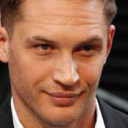

In [7]:
image1

# Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [8]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        
        return torch.cat(xs, dim=1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi().eval().cuda()

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [9]:
from scipy.spatial.distance import cosine

def best_similar(query_image, mask, n=100):
    # вернём индексы изобажений в базе
    main_features=phi(to_tensor(query_image).unsqueeze(0).cuda())[0]
    data =[]
    for i in range(200000):
        if mask[i]==True:
            image=load_image(filepaths[i])
            data.append(cosine(phi(to_tensor(image).unsqueeze(0).cuda())[0].cpu(),main_features.cpu()))
        else:
            data.append(+100500)
    print(len(data))
    pics = np.argsort(np.array(data))[:25]
    plt.figure(figsize=(6,6))
    for num, i in enumerate(pics):
        plt.subplot(5,5,num+1)
        plt.imshow(load_image(filepaths[i]))
    plt.show()
    
    return np.argsort(np.array(data))[:n]

200000


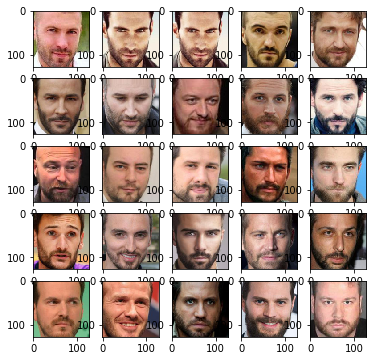

In [74]:
beard_ind=best_similar(query_image=image1,mask= get_mask(age='senior',race='caucasian', gender='male', facial_hair='beard'))

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [10]:
def central(indexces1,indexces2):
    #indexes1-нет фичи, indexes2-есть фича
    mean1=np.mean(np.array([(phi(to_tensor(np.array(load_image(filepaths[i]))).unsqueeze(0).cuda()).cpu().detach().numpy()[0]) 
                     for i in indexces1]),axis=0)
    mean2=np.mean(np.array([(phi(to_tensor(np.array(load_image(filepaths[i]))).unsqueeze(0).cuda()).cpu().detach().numpy()[0]) 
                     for i in indexces2]),axis=0)
      
    return mean2-mean1

In [11]:
def special_feature(quare_image,mask_with_feat,mask_without_feat):
    index_with=best_similar(quare_image,mask=mask_with_feat)
    index_without=best_similar(quare_image,mask=mask_without_feat)
    return central(indexces2=index_with,indexces1=index_without)

200000


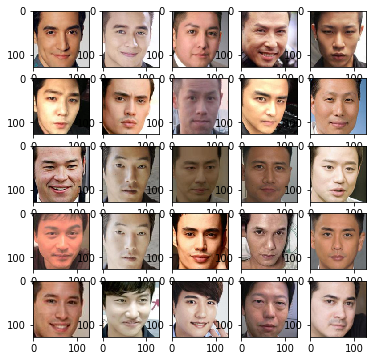

In [85]:
index_with=best_similar(image1,mask=get_mask(age='senior',race='asian', gender='male', facial_hair='shaved'))


200000


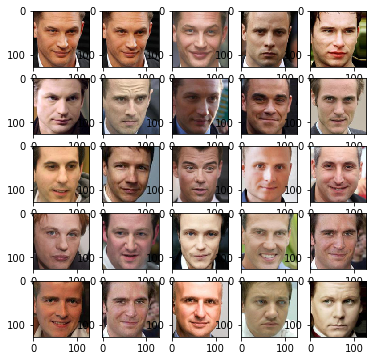

In [90]:
index_without=best_similar(image1,mask=get_mask(age='senior',race='caucasian', gender='male', facial_hair='shaved'))

200000


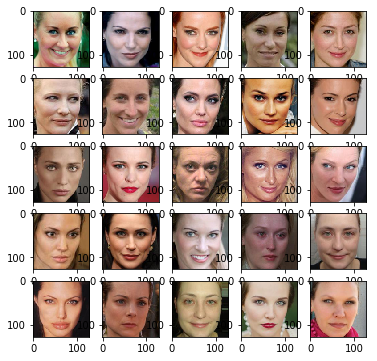

In [ ]:
lady_feature=special_feature(image1,mask_with_feat=get_mask(age='senior',race='caucasian', gender='female', facial_hair='shaved'),
                           mask_without_feat=get_mask(age='senior',race='caucasian', gender='male', facial_hair='shaved'))

In [101]:
asian_feature=central(indexces2=index_with,indexces1=index_without)

In [ ]:
torch.save(f='as_feature',obj=asian_feature)

In [ ]:
torch.save(f='lady_feature',obj=lady_feature)

In [12]:
asian_feature=torch.load(f="as_feature")

In [13]:
lady_feature=torch.load(f="lady_feature")

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [15]:
def calc_losses(x_o, shifted_features,alpha=0.5):
    

    feat_xo=(phi((x_o))[0]).requires_grad_()

    loss_mse = torch.mean(torch.pow(feat_xo-shifted_features,2)).cuda()
    loss_totalvar=torch.mean(torch.pow((x_o[:,:,:-1,:-1]-x_o[:,:,1:,:-1]),2)+
                             (torch.pow((x_o[:,:,:-1,:-1]-x_o[:,:,:-1,1:]),2))).cuda()

            
    # суммируем loss-ы со специально подобранным коэффициентом
    return loss_mse + alpha*loss_totalvar

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [72]:
from tqdm import tqdm_notebook

In [103]:
def add_feature(shifted_features, x_o,alpha=0.5,n_epoh=500,lr=0.001):

    # инициализируем оптимизируемое изображение
    # из изображения контента, помечаем его как "оптимизируемое"
    x_o = x_o.requires_grad_()

# в качестве потимизатора можно взять любой, поэтому возьмем оптимизатор Адам
    optimizer = optim.Adam([x_o],lr=lr)

    for t in tqdm_notebook(range(n_epoh)):

#обнуляем градиенты
        optimizer.zero_grad()

        loss = calc_losses(x_o.unsqueeze(0).cuda(), shifted_features,alpha=alpha)
        loss.backward()
        optimizer.step()

        if t==1000:
            lr=lr/2
            for params in optimizer.param_groups:
                params['lr']=lr

        # не забываем клипать изображение,т.к. определенные пиксели могут выйти за пределы 1-цы
        x_o.data.clamp_(0, 1)
    
    # "вырываем" тензор из графа
    return x_o.detach().cpu()

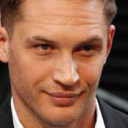

In [174]:
image1

100%|██████████| 2000/2000 [00:12<00:00, 154.69it/s]


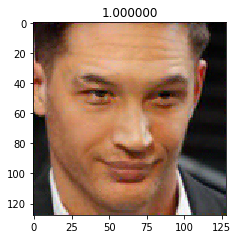

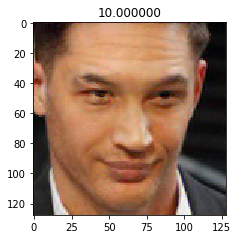

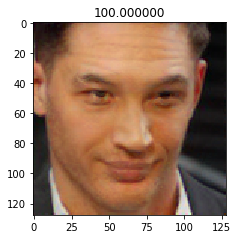

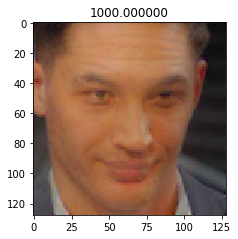

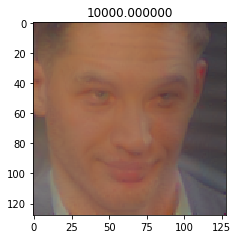

In [29]:
# ваш код + визуализация результата
import matplotlib.pyplot as plt
import datetime


phi_image = np.array(phi(to_tensor(image1).unsqueeze(0).cuda()).cpu().detach()[0])

for i in range(0,5):
    image2 = add_feature(torch.tensor(2.0*asian_feature + phi_image).cuda(),to_tensor(image1), alpha=10**i, n_epoh=2000) 
    plt.figure(figsize=(20,5))
    plt.subplot(1,5,i+1)
    plt.imshow(np.moveaxis(image2.numpy(),0,2))
    plt.gca().set_title("%f"%10**i)

### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

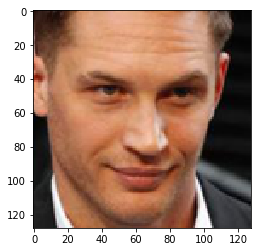

In [178]:
plt.imshow(image1)

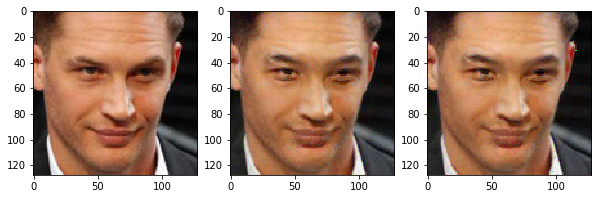

In [93]:
# ваш код + визуализация результата
import matplotlib.pyplot as plt


phi_image = np.array(phi(to_tensor(image1).unsqueeze(0).cuda()).cpu().detach()[0])
image2 = add_feature(torch.tensor(2.5*(asian_feature) + phi_image).cuda(),to_tensor(image1),alpha=10,n_epoh=1500
                             ) 

image0 = add_feature(torch.tensor(phi_image).cuda(),to_tensor(image1),
                             alpha=1e-1,n_epoh=2000) 


plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(np.array(image1))

plt.subplot(1,3,2)
plt.imshow(np.moveaxis(image2.numpy(), 0,2))

plt.subplot(1,3,3)
plt.imshow(np.moveaxis(image2.numpy(), 0,2) - (np.array(image1)/256 - (np.moveaxis(image0.numpy(), 0,2))))
plt.show()

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

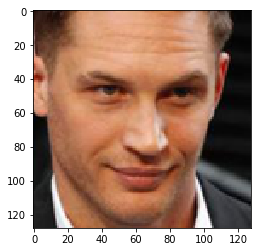

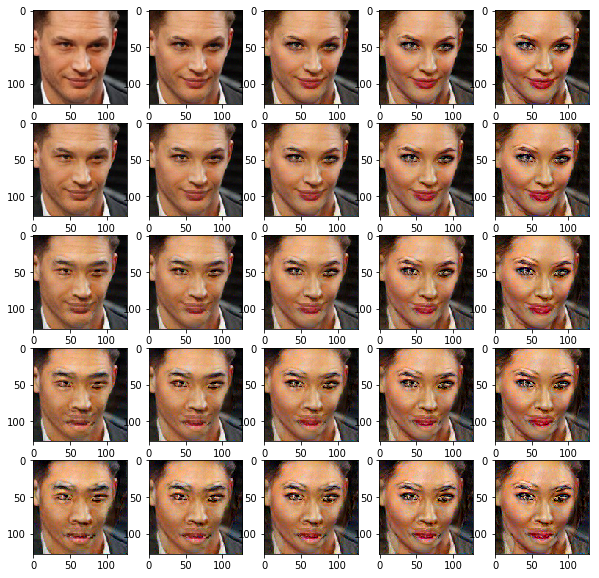

In [92]:
# ваш код + визуализация результата
phi_image = np.array(phi(to_tensor(image1).unsqueeze(0).cuda()).cpu().detach()[0])
plt.imshow(image1)
plt.figure(figsize=(10,10))
for i in range(0,5):
    for j in range(0,5):
        image2 = add_feature(torch.tensor(i*1.5*asian_feature +j*1.5*lady_feature+ phi_image).cuda(),to_tensor(image1),
                             alpha=100, n_epoh=2000) 
        plt.subplot(5,5,5*i+j+1)
        plt.imshow(np.moveaxis(image2.numpy(),0,2))
plt.show()